In [14]:
#----------Filter usable data-------------

import pandas as pd

df = pd.read_csv("7282_1_dedupe_cleaned.csv")

# Keep only rows with both rating and text
df = df[df["reviews.rating"].notna() & df["reviews.text"].notna()]

In [15]:
#----------Compute an average rating per hotel-----------

hotel_stats = (
    df.groupby("name")["reviews.rating"]
      .agg(["count", "mean"])
      .reset_index()
      .rename(columns={"count": "n_reviews", "mean": "avg_rating"})
)

# keep hotels with enough reviews to be meaningful
hotel_stats = hotel_stats[hotel_stats["n_reviews"] >= 10]

In [16]:
#----------Define rating tiers----------

def rating_tier(x):
    if x < 3.0:
        return "low"
    elif x < 4.0:
        return "mid"
    else:
        return "high"

hotel_stats["rating_tier"] = hotel_stats["avg_rating"].apply(rating_tier)

#Merge back to original df:
df = df.merge(hotel_stats[["name", "rating_tier"]], on="name", how="inner")

In [17]:
#----------Sample up to 20 reviews per hotel----------
df_sampled = (
    df.groupby("name")
      .head(20)          # up to 20 per hotel
      .reset_index(drop=True)
)

#Running transformers on all ~34k reviews might be slow, so we keep a sample reviews of about 8000.

In [18]:
#----------Split each review into shorter sentences----------

import re

def simple_sentence_split(text):
    # Rough split on ., !, ? 
    # Handles multiple spaces; trims empty sentences
    parts = re.split(r'[.!?]+', str(text))
    return [p.strip() for p in parts if p.strip()]

df_sampled["sentences"] = df_sampled["reviews.text"].apply(simple_sentence_split)


#----------Explode sentences into separate rows----------
sent_df = df_sampled.explode("sentences").rename(columns={"sentences": "sentence"})
sent_df = sent_df[sent_df["sentence"].str.len() > 5]  # drop super-short fragments
sent_df = sent_df.reset_index(drop=True)
#Now each row = one sentence with its hotel, rating tier, etc

In [19]:
#----------Pick a small, clear set of hotel aspects:----------
ASPECT_LABELS = [
    "service",
    "location",
    "wifi",
    "food",
    "parking",
    "price",
    "none"
]

In [20]:
import re

# Define keyword lists for each aspect (you can expand this later)
ASPECT_KEYWORDS = {
    "cleanliness": [
        "clean", "dirty", "filthy", "spotless", "stain", "stains",
        "smell", "odor", "odour", "mold", "mould", "bathroom"
    ],
    "staff": [
        "staff", "employee", "employees", "reception", "receptionist",
        "front desk", "manager", "host", "service", "check in", "check-in"
    ],
    "room": [
        "room", "bed", "beds", "suite", "noise", "noisy", "quiet",
        "comfort", "comfortable", "uncomfortable", "furniture"
    ],
    "location": [
        "location", "close to", "far from", "distance", "neighborhood",
        "neighbourhood", "area", "safe", "unsafe", "walking distance"
    ],
    "wifi": [
        "wifi", "wi-fi", "internet", "connection", "network"
    ],
    "price": [
        "price", "expensive", "cheap", "value", "worth", "overpriced"
    ]
}

def detect_aspect(sentence):
    s = sentence.lower()
    for aspect, kws in ASPECT_KEYWORDS.items():
        for kw in kws:
            if kw in s:
                return aspect
    return "none"

sent_df["aspect_label"] = sent_df["sentence"].apply(detect_aspect)

# Keep only sentences where we detected some aspect
sent_df = sent_df[sent_df["aspect_label"] != "none"].reset_index(drop=True)


In [ ]:
#Sample a manageable subset for BERT sentiment
N_SENTENCES = 10000  

sent_small = sent_df.sample(
    n=min(N_SENTENCES, len(sent_df)),
    random_state=42
).reset_index(drop=True)


In [ ]:
#Run ONLY the sentiment model on sent_small

from transformers import pipeline

sentiment_classifier = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
    # if you have GPU: add device=0
)


Device set to use cpu


In [ ]:
#Run model in batches 
from tqdm.auto import tqdm

BATCH_SIZE = 32
sentiment_labels = []
sentiment_scores = []

for i in tqdm(range(0, len(sent_small), BATCH_SIZE)):
    batch = sent_small["sentence"].iloc[i:i+BATCH_SIZE].tolist()
    outputs = sentiment_classifier(batch)
    for out in outputs:
        sentiment_labels.append(out["label"])   # like '4 stars'
        sentiment_scores.append(out["score"])

sent_small["sent_label_raw"] = sentiment_labels
sent_small["sent_score"] = sentiment_scores
def map_sentiment(label):
    n = int(label.split()[0])  # '4 stars' -> 4
    if n <= 2:
        return "neg"
    elif n == 3:
        return "neu"
    else:
        return "pos"

sent_small["sentiment"] = sent_small["sent_label_raw"].apply(map_sentiment)

def sentiment_numeric(s):
    if s == "neg": return -1
    if s == "neu": return 0
    return 1

sent_small["sentiment_num"] = sent_small["sentiment"].apply(sentiment_numeric)


  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
#Aggregate aspect sentiment by hotel
aspect_hotel = (
    sent_small
    .groupby(["name", "rating_tier", "aspect_label"])
    .agg(
        n_sentences=("sentence", "count"),
        mean_sentiment=("sentiment_num", "mean"),
        pos_share=("sentiment", lambda x: (x == "pos").mean()),
        neg_share=("sentiment", lambda x: (x == "neg").mean()),
    )
    .reset_index()
)

In [ ]:
#rate tier (for hypothesis):
aspect_tier = (
    aspect_hotel
    .groupby(["rating_tier", "aspect_label"])
    .agg(
        mean_pos_share=("pos_share", "mean"),
        mean_neg_share=("neg_share", "mean")
    )
    .reset_index()
)


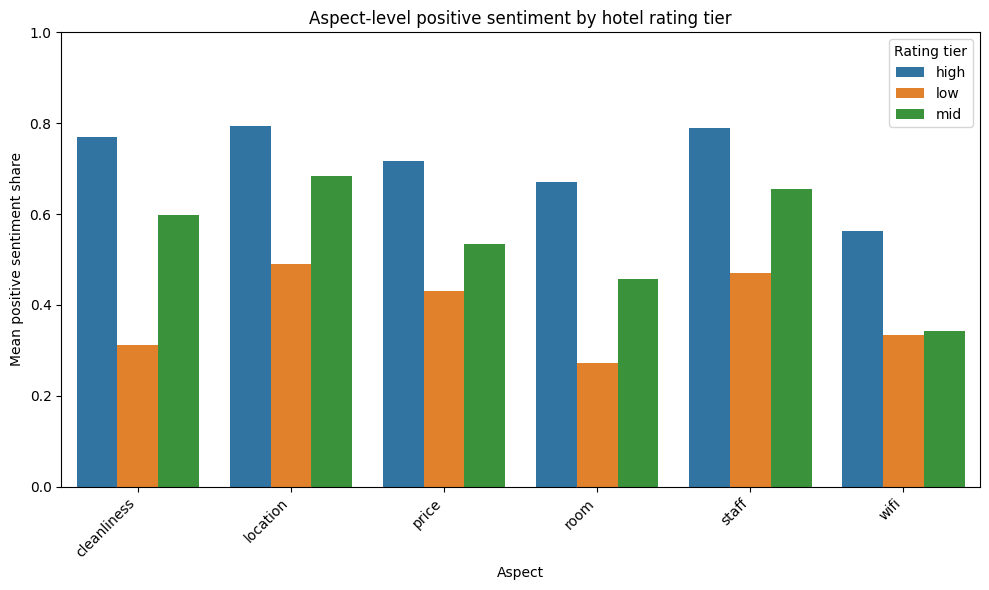

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=aspect_tier,
    x="aspect_label",
    y="mean_pos_share",
    hue="rating_tier"
)

plt.ylim(0, 1)
plt.ylabel("Mean positive sentiment share")
plt.xlabel("Aspect")
plt.title("Aspect-level positive sentiment by hotel rating tier")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Rating tier")
plt.tight_layout()
plt.show()
